In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# The "old" file

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import datetime, bz2, csv, collections
import lzma
import opencrimedata.chicago as chicago
import numpy as np
import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:4326"})

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.abspath(os.path.join("..", "..", "..", "..", "Data"))
filename = os.path.join(datadir, "chicago_all.csv.xz")
filename_old = os.path.join(datadir, "chicago_all_old.csv")

def gen():
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from chicago.load_only_with_point(f)

def gen_old():
    yield from chicago.load_only_with_point(filename_old)
        
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [4]:
next(gen_old())

Row(id='9625135', crime_type='BATTERY', crime_subtype='DOMESTIC BATTERY SIMPLE', location='APARTMENT', address='087XX S KINGSTON AVE', datetime=datetime.datetime(2014, 5, 24, 23, 53), point=(-87.56256025376493, 41.736431989689265))

# Check the data (mostly) agrees

In [5]:
data_new = {row.id : row for row in gen()}

In [6]:
data_old = {row.id : row for row in gen_old()}

## Address and dates match

Except for small differences.

In [7]:
len(data_new), len(data_old)

(6323451, 5492749)

In [8]:
min(row.datetime for row in data_new.values()), max(row.datetime for row in data_new.values())

(datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2017, 8, 9, 23, 59))

In [9]:
min(row.datetime for row in data_old.values()), max(row.datetime for row in data_old.values())

(datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2014, 5, 24, 23, 53))

In [10]:
in_new_only_count = 0
address_different_count = 0
date_different_count = 0
for crime_id, row in data_new.items():
    if crime_id not in data_old:
        in_new_only_count += 1
        continue
    row_old = data_old[crime_id]
    if row.address != row_old.address:
        address_different_count += 1
    if row.datetime != row_old.datetime:
        date_different_count += 1
in_new_only_count, address_different_count, date_different_count

(836461, 1055, 56)

In [11]:
in_old_only_count = sum(crime_id not in data_new for crime_id in data_old)
in_old_only_count

5759

In [12]:
crime_type_different = 0
crime_subtype_different = 0
location_different = 0
for crime_id, row in data_new.items():
    if crime_id not in data_old:
        continue
    row_old = data_old[crime_id]
    if row.crime_type != row_old.crime_type:
        crime_type_different += 1
    if row.crime_subtype != row_old.crime_subtype:
        crime_subtype_different += 1
    if row.location != row_old.location:
        location_different += 1
crime_type_different, crime_subtype_different, location_different

(11346, 429317, 73)

# See how the locations change

Only use events with matching address, datetimes and locations

In [13]:
joined_data = []
for crime_id, row in data_new.items():
    if crime_id not in data_old:
        continue
    row_old = data_old[crime_id]
    if (row.address != row_old.address or row.datetime != row_old.datetime
            or row.location != row_old.location):
        continue
    joined_data.append((row.id, row.address, row.datetime, row.location, row.point, row_old.point))

In [14]:
with bz2.open("temp.csv.bz2", "wt", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "block", "datetime", "location", "new", "old"])
    writer.writerows(joined_data)

## Reload and perform analysis

In [5]:
def parse_coord(x):
    return tuple(float(t) for t in x[1:-1].split(", "))

assert parse_coord('(-87.531655723, 41.698387427)') == (-87.531655723, 41.698387427)

with bz2.open("temp.csv.bz2", "rt") as f:
    reader = csv.reader(f)
    assert next(reader) == ["id", "block", "datetime", "location", "new", "old"]
    joined_data = [(row[0], row[1], datetime.datetime.strptime(row[2], "%Y-%m-%d %H:%M:%S"),
                   row[3], parse_coord(row[4]), parse_coord(row[5]))
                            for row in reader]

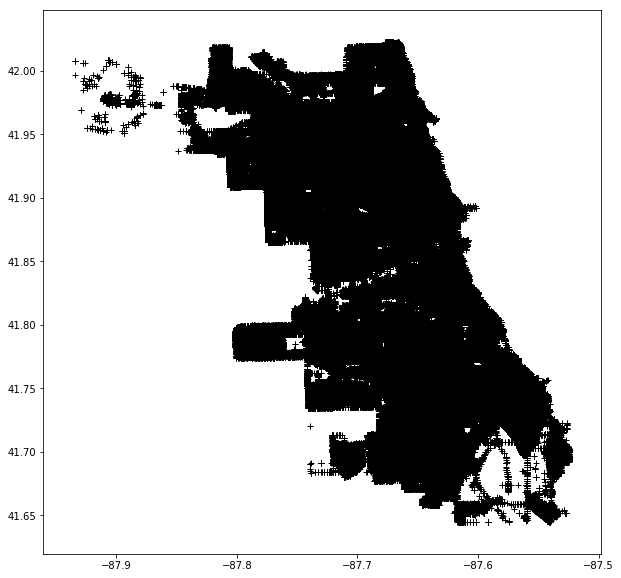

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter([row[4][0] for row in joined_data], [row[4][1] for row in joined_data],
           marker="+", color="black", linewidth=1)

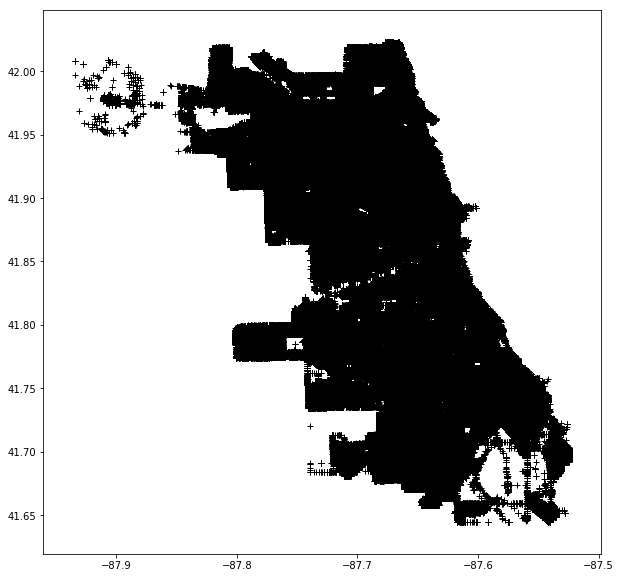

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter([row[5][0] for row in joined_data], [row[5][1] for row in joined_data],
           marker="+", color="black", linewidth=1)

### 2001 data

Check that the vast majority of the 2001 data does not change (up to numerial error).

In [8]:
big_2001_moves = 0
total_2001_count = 0
for row in joined_data:
    if row[2] < datetime.datetime(2002,1,1):
        total_2001_count += 1
        d = np.sqrt(np.sum((np.asarray(row[4]) - np.asarray(row[5]))**2))
        if not d < 1e-8:
            big_2001_moves += 1
big_2001_moves, total_2001_count

(558, 482713)

In [9]:
class Contains():
    """Makes a callable object which detects if a point is in a rectangular region
    up to some buffer, which is percentage of overall size."""
    def __init__(self, region, buffer = 1):
        xd = region.xmax - region.xmin
        self.xmin = region.xmin - xd * buffer
        self.xmax = region.xmax + xd * buffer
        yd = region.ymax - region.ymin
        self.ymin = region.ymin - yd * buffer
        self.ymax = region.ymax + yd * buffer
        
    def __call__(self, x, y):
        return self.xmin <= x and x <= self.xmax and self.ymin <= y and y <= self.ymax
   
def plot_block(ax, block, size=0.00001, draw_all=False, draw_lines = True):
    points, points_old = [], []
    for row in joined_data:
        if row[1] ==  block:
            points.append( tilemapbase.project(*row[4]) )
            points_old.append( tilemapbase.project(*row[5]) )
    points, points_old = np.asarray(points), np.asarray(points_old)
    
    x, y = np.mean(points, axis=0)
    ex = tilemapbase.Extent.from_centre(x, y, xsize=size)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
    plotter.plot(ax)
    
    if draw_all:
        con = Contains(ex)
        points, points_old = [], []
        for row in joined_data:
            x, y = tilemapbase.project(*row[4])
            if con(x, y):
                points.append( (x,y) )
                points_old.append( tilemapbase.project(*row[5]) )
        points, points_old = np.asarray(points), np.asarray(points_old)
    
    ax.scatter(*points.T, marker="x", color="black", linewidth=1)
    if draw_lines:
        lines = [ [[x,y], [xx,yy]] for (x,y), (xx,yy) in zip(points, points_old) ]
        ax.add_collection(matplotlib.collections.LineCollection(lines, linewidth=1, color="black"))
    else:
        ax.scatter(*points_old.T, marker="+", color="black", linewidth=1)

Examples from before

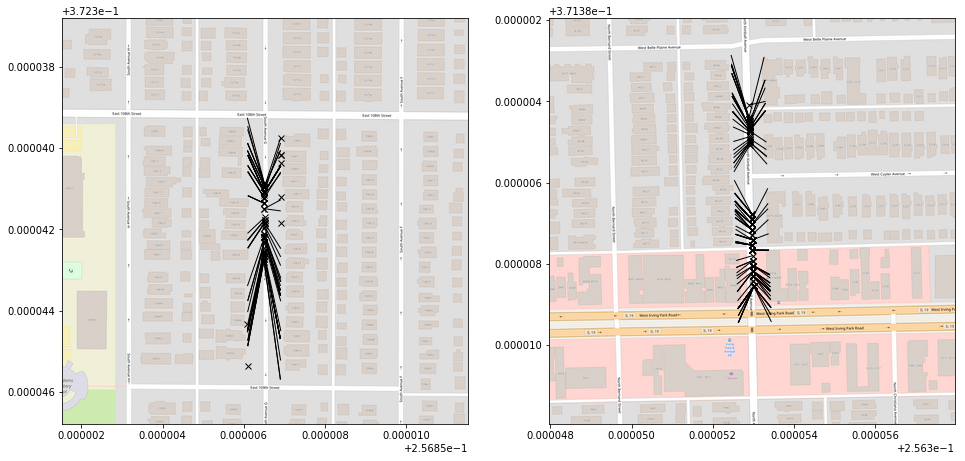

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))

for ax, block in zip(axes, ["108XX S AVENUE G", "040XX N KIMBALL AVE"]):
    plot_block(ax, block)

Distinct clusters in the main north/south road now seem to merge together.

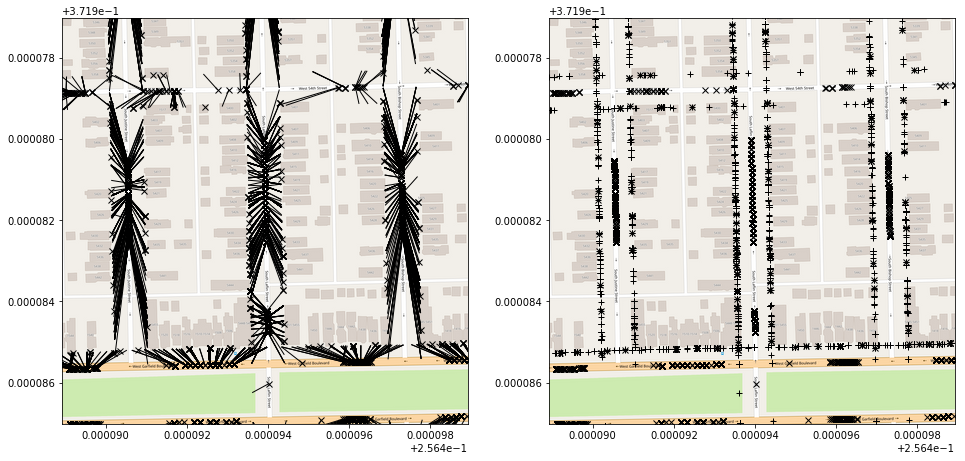

In [11]:
block = "054XX S LAFLIN ST"
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], block, draw_all=True)
plot_block(ax[1], block, draw_all=True, draw_lines=False)

The "outlier" (in this case) actually seems to reflect geographic reality.

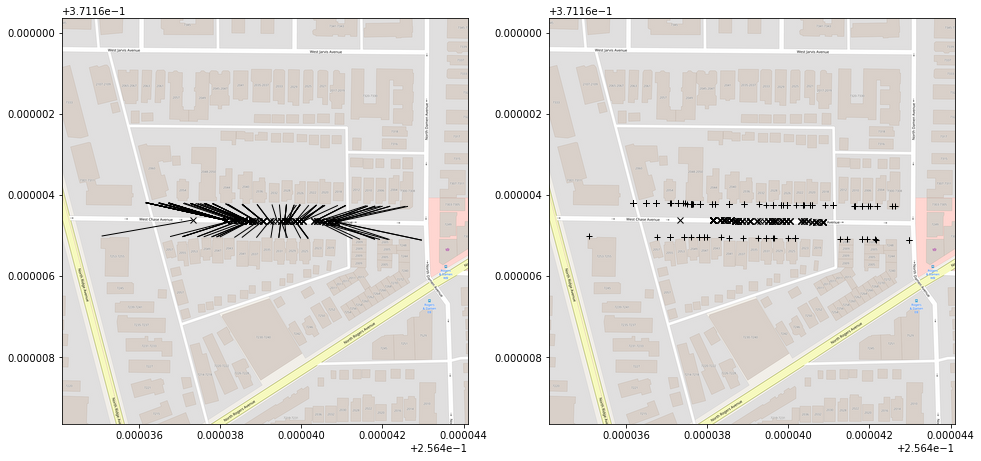

In [12]:
block = "020XX W CHASE AVE"
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], block, draw_all=False)
plot_block(ax[1], block, draw_all=False, draw_lines=False)

Not that interesting: an outlier from before now disappears (presumably doesn't match, in some way, to the old data set).

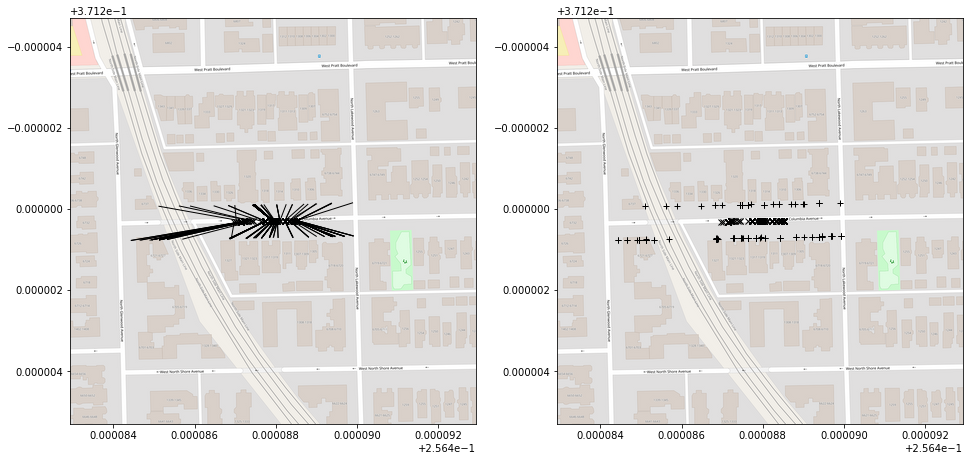

In [13]:
block = "013XX W COLUMBIA AVE"
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], block, draw_all=False)
plot_block(ax[1], block, draw_all=False, draw_lines=False)

Rather puzzling:

- Distinct clusters do now seem to merge together, at least approximately.
- Notice the bottom "cluster" in the "old" data seems to correspond to nothing geographically relavant
- Notice the odd left/right bias at the top and bottom.
- Below we plot the next block north, and we see the left/right bias repeated.
- This does actually reflect geographic reality-- here one side of the road is 65XX and the other 66XX

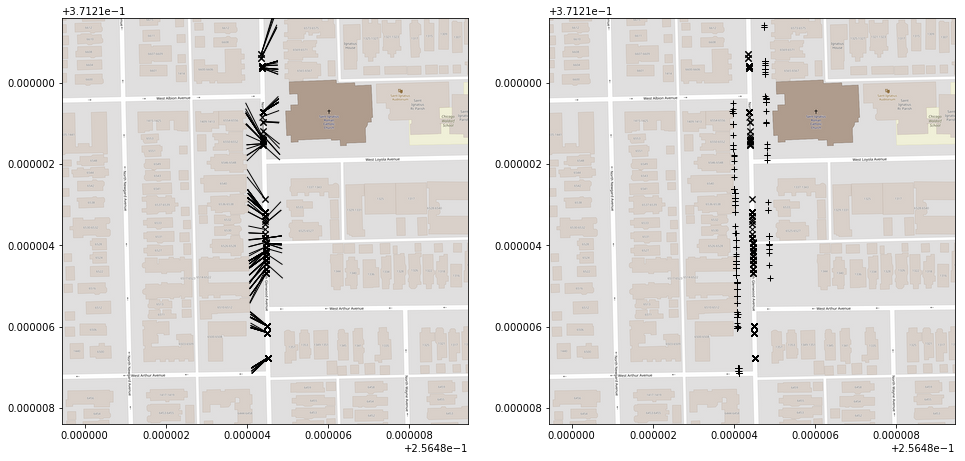

In [14]:
block = "065XX N GLENWOOD AVE"
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], block, draw_all=False)
plot_block(ax[1], block, draw_all=False, draw_lines=False)

Look at the `Location` field.  Interesting is the cluster of `CHURCH/SYNAGOGUE/PLACE OF WORSHIP` entries.

In [15]:
block = "065XX N GLENWOOD AVE"
y_to_location = collections.defaultdict(list)
for row in joined_data:
    if row[1] == block:
        x, y = tilemapbase.project(*row[4])
        y_to_location[ y - 0.37121 ].append(row[3])
y_to_location

defaultdict(list,
            {-7.231432772036861e-07: ['RESIDENCE', 'APARTMENT', 'RESIDENCE'],
             -6.205728365071828e-07: ['APARTMENT', 'RESIDENCE', 'RESIDENCE'],
             -4.25606885345875e-07: ['STREET',
              'APARTMENT',
              'STREET',
              'SIDEWALK',
              'RESIDENTIAL YARD (FRONT/BACK)',
              'STREET',
              'RESIDENCE',
              'APARTMENT',
              'STREET',
              'STREET'],
             -3.7432172356188786e-07: ['RESIDENCE',
              'APARTMENT',
              'APARTMENT',
              'APARTMENT',
              'RESIDENTIAL YARD (FRONT/BACK)',
              'SIDEWALK',
              'RESIDENCE'],
             7.131678086413906e-07: ['CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
              'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
              'PARKING LOT/GARAGE(NON.RESID.)',
              'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
              'OTHER',
              'ALLEY',
              'STREET',


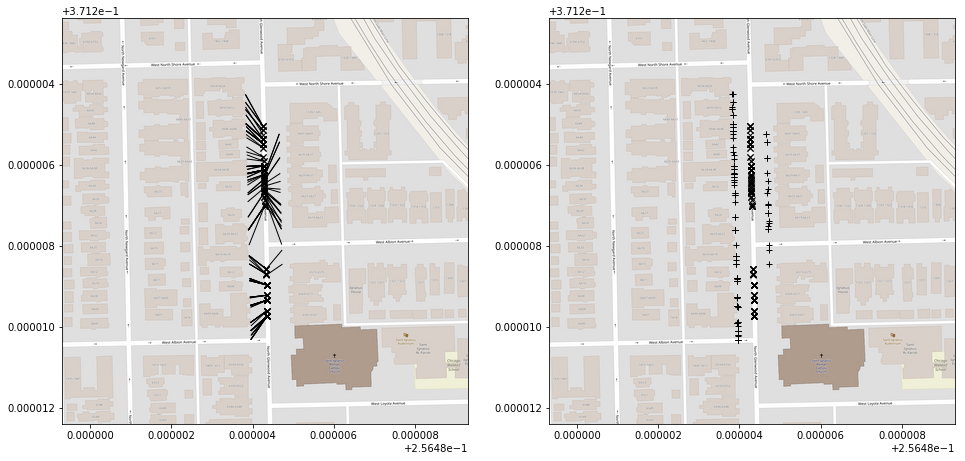

In [16]:
block = "066XX N GLENWOOD AVE"
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], block, draw_all=False)
plot_block(ax[1], block, draw_all=False, draw_lines=False)

# Conclusions

This is not an exact science...  but we might claim the following:

- Little evidence that the "old" geo-coding is "accurate".  Points seem to correspond to a continuum either side of the road, and don't align with buildings or addresses.
- In the old data, the "clumps" / "clusters" somewhat disappear.
- If we look at the "clusters" in the new data, then they do seem to correspond to geographical reality.  In the above example, the cluster outside the church is the only cluster to feature "location" descriptions of a church.
- The old data does seem to contain some "side of street" information missing in the new data.


# Save plots for article

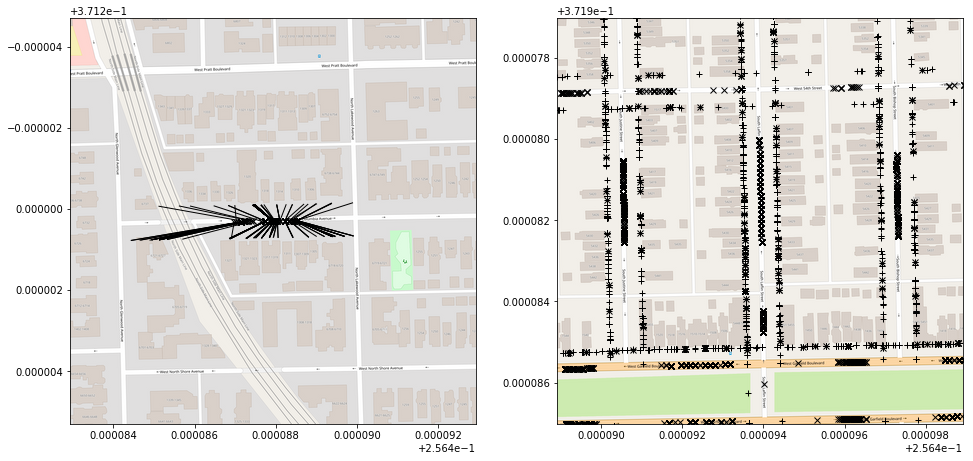

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
plot_block(axes[0], "013XX W COLUMBIA AVE", draw_all=False)
plot_block(axes[1], "054XX S LAFLIN ST", draw_all=True, draw_lines=False)

In [18]:
fig.savefig("Chicago_example1.png", dpi=150)

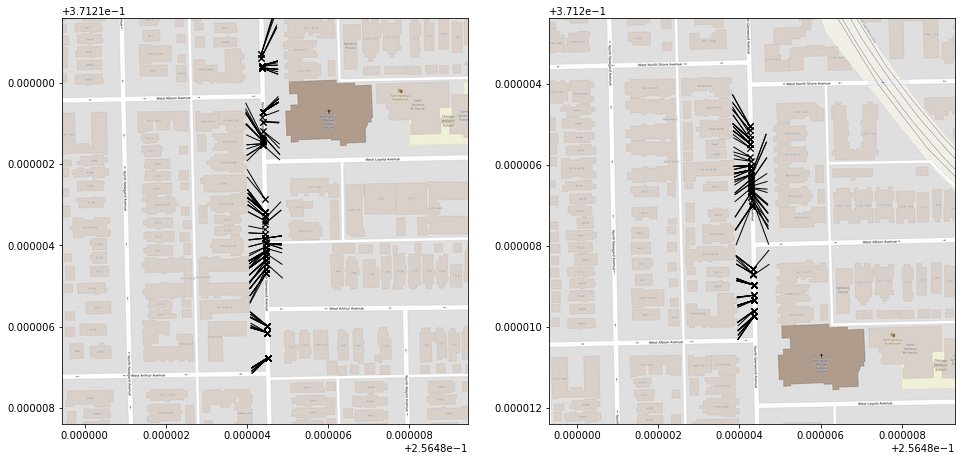

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
plot_block(ax[0], "065XX N GLENWOOD AVE", draw_all=False)
plot_block(ax[1], "066XX N GLENWOOD AVE", draw_all=False)

In [20]:
fig.savefig("Chicago_example2.png", dpi=150)

# Save out as shapefile

In [21]:
import geopandas as gpd
import shapely.geometry
import open_cp.geometry
open_cp.geometry.configure_gdal()

In [22]:
frame = gpd.GeoDataFrame({"block" : [row[1] for row in joined_data],
                 "time" : [str(row[2]) for row in joined_data],
                 "location" : [row[3] for row in joined_data]
                 })
frame.geometry = [shapely.geometry.LineString([row[4], row[5]]) for row in joined_data]
frame.crs = {"init":"epsg:4326"}
frame.head()

,block,location,time,geometry
0,108XX S AVENUE G,RESIDENCE,2006-10-12 10:58:00,"LINESTRING (-87.531655723 41.698387427, -87.53..."
1,060XX S WOLCOTT AVE,RESIDENCE,2006-12-16 06:30:00,"LINESTRING (-87.67161153799999 41.784308275, -..."
2,014XX E 74TH ST,SIDEWALK,2006-12-17 19:03:00,"LINESTRING (-87.590369552 41.760550978, -87.59..."
3,006XX E 90TH PL,STREET,2006-12-17 21:00:00,"LINESTRING (-87.608883201 41.730199189, -87.60..."
4,040XX N KIMBALL AVE,RESIDENCE,2006-12-17 19:30:00,"LINESTRING (-87.712927149 41.9544026, -87.7130..."


In [23]:
for _, row in frame[frame.block == "065XX N GLENWOOD AVE"].iterrows():
    break
x, y = list(row.geometry.coords)[0]
region = shapely.geometry.Point(x, y).buffer(0.01)

part = frame[frame.geometry.map(lambda g : g.intersects(region))]

In [24]:
part.to_file("chicago_old_to_new")

In [25]:
locs = frame.location.unique()
locs.sort()
locs

array(['', 'ABANDONED BUILDING', 'AIRCRAFT',
       'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
       'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
       'AIRPORT EXTERIOR - NON-SECURE AREA',
       'AIRPORT EXTERIOR - SECURE AREA', 'AIRPORT PARKING LOT',
       'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
       'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
       'AIRPORT TERMINAL MEZZANINE - NON-SECURE AREA',
       'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
       'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA',
       'AIRPORT TRANSPORTATION SYSTEM (ATS)',
       'AIRPORT VENDING ESTABLISHMENT', 'AIRPORT/AIRCRAFT', 'ALLEY',
       'ANIMAL HOSPITAL', 'APARTMENT', 'APPLIANCE STORE', 'ATHLETIC CLUB',
       'ATM (AUTOMATIC TELLER MACHINE)', 'AUTO', 'BANK', 'BANQUET HALL',
       'BAR OR TAVERN', 'BARBER SHOP/BEAUTY SALON', 'BARBERSHOP',
       'BASEMENT', 'BOAT/WATERCRAFT', 'BOWLING ALLEY', 'BRIDGE',
       'CAR WASH', 'CEMETARY', 'CHA APARTMENT', 'CHA BREEZEWAY',


In [26]:
churches = ['CHURCH/SYNAGOGUE/PLACE OF WORSHIP', 'CHURCH PROPERTY', 'CHURCH']
part = frame[frame.location.map(lambda s : s in churches)]
part.to_file("chicago_old_to_new")